# Polish grid overnight performance
Last night I ran my overnight script for evaluating temporal instanton algorithm performance on the 2383-bus Polish network. The results show a decrease in solution time, but a marked increase in memory allocation. The left subfigures below show previous performance, while the right subfigures show last night's results. There is nothing about the changes I made yesterday that would require additional memory allocation, so I probably made a mistake that converted a matrix to dense form.

![](../images/2016-01-20-polish-reuse-null.png)

I'm not sure where the memory is going.

I have three RTS-96 files to compare. The memory allocation difference may be due to changes in how Julia reports numbers.

* `rts96_scaling-2016-01-20`. Created using today's Julia on code from December (checked out commit 2ce736b).
* `rts96_scaling-2016-01-19`. Created this morning using today's Julia on today's code.
* `rts96_scaling-2015-12-09`. Old file using old Julia on old instanton code.

In [20]:
using PyPlot, DataFrames
PyPlot.svg(true)
fname = "rts96_scaling.csv"
d0120 = readtable("../data/rts96_scaling-2016-01-20.csv",header=true)
d0119 = readtable("../data/rts96_scaling-2016-01-19.csv",header=true)
d1209 = readtable("../data/rts96_scaling-2015-12-09.csv",header=true)

x0120 = d0120[:nr].*d0120[:nt]
y0120 = d0120[:alloc]/1e6

x0119 = d0119[:nr].*d0119[:nt]
y0119 = d0119[:alloc]/1e6

x1209 = d1209[:nr].*d1209[:nt]
y1209 = d1209[:alloc]/1e6

288-element DataArrays.DataArray{Float64,1}:
 3.35922
 3.39422
 3.43226
 3.46746
 3.50549
 3.55051
 3.586  
 3.62195
 3.65813
 3.69456
 3.73248
 3.7673 
 3.85747
 ⋮      
 4.30749
 4.32899
 4.35526
 4.37653
 4.40109
 4.42419
 4.4735 
 4.49669
 4.55952
 4.58056
 4.64376
 4.66608

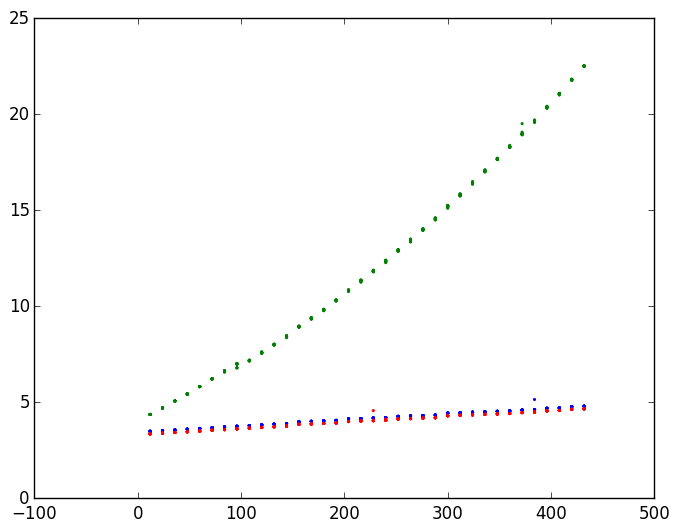

PyObject <matplotlib.collections.PathCollection object at 0x7fc5c5a11668>

In [28]:
scatter(x0120,y0120,c="b",marker=".",edgecolor="none")
hold(true)
scatter(x0119,y0119,c="g",marker=".",edgecolor="none")
scatter(x1209,y1209,c="r",marker=".",edgecolor="none")

So results obtained from using up-do-date Julia match the ones from last December. The December analysis is repeatable, so there is something wrong with the new code.

What on earth could cause such an allocation runaway? It's somewhere between commits 2ce736b and 9e12be4. The only differences between the two are in moving the null basis computation outside the line loop. Surely this minor change cannot result in ridiculous memory allocation.

What if it has to do with using kernel_backsubs?

In [1]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton

d = testcase("timing")
o = solve_temporal_instanton(d)
Profile.clear_malloc_data()
o = solve_temporal_instanton(d)

# quit, then run julia again
using Coverage, JLD
m = analyze_malloc("../src")
save("../../2ce736b-alloc.jld","m",m)

@allocated solve_temporal_instanton(d)

I need more detailed info. I can store the results of analyze_malloc() for each commit and see what falls out.

In [3]:
using JLD, Coverage
before = load("../data/2ce736b-alloc.jld","m")
after = load("../data/9e12be4-alloc.jld","m")

596-element Array{Coverage.MallocInfo,1}:
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",10)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",76)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",77)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",80)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",81)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",82)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",83)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",85)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",86)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",88)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",90)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",91)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem

In [4]:
before

600-element Array{Coverage.MallocInfo,1}:
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",10)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",76)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",77)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",80)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",81)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",82)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",83)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",85)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",86)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",88)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",90)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",91)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem

In [5]:
after

596-element Array{Coverage.MallocInfo,1}:
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",10)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",76)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",77)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",80)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",81)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",82)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",83)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",85)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",86)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",88)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",90)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem",91)                        
 Coverage.MallocInfo(0,"../src/DataLoad.jl.mem

In [ ]:
# bash
